## Correlating NAO and Overturning anomalies

In this notebook, we compute correlations between NAO and overturning anomalies. Since overturning strength could evolve in some definite time due to atmospheric forcing, we consider time-lagged correlation. Moreoever, oceans may retain memomry for some time. Thus, it might be more approapriate to use intergral definitions.

Assuming that surface heat flux anomalies, which are strongly correlated to NAO phases, affect overturning with some time lag, we could write the following


$\psi(y,t+\tau) \propto \int_{t_0}^{t}\text{NAO}dt$


In [1]:
# Load libraries

import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar, visualize

In [2]:
#from dask.distributed import Client, LocalCluster

#cluster = LocalCluster()
#client = Client()

#client

In [3]:
ppdir = "/home/users/hkhatri/DePreSys4_Data/Data_Anomaly_Compute/"

ds_NAO = xr.open_dataset(ppdir + "NAO_SLP_Anomaly.nc")

print(ds_NAO)

<xarray.Dataset>
Dimensions:     (start_year: 57, r: 10, time: 125)
Coordinates:
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 2016
Dimensions without coordinates: r, time
Data variables:
    NAO         (start_year, r, time) float64 ...
    P_south     (start_year, r, time) float64 ...
    P_north     (start_year, r, time) float64 ...
    time_val    (start_year, time) object ...


In [4]:
ppdir="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

# variable list to keep in the dataset
var_list = ['hfbasin_atlantic', 'sltbasin_atlantic', 'zomsfatl']

ds = xr.open_dataset(ppdir+"Overturning_z.nc", decode_times=False, chunks={'r':1, 'y':1})
ds = ds.get(var_list)
ds = xr.decode_cf(ds)

print(ds)

<xarray.Dataset>
Dimensions:            (start_year: 57, r: 10, time_counter: 125, y: 451, x: 1, depthw: 75)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time_centered      (start_year, time_counter) object dask.array<chunksize=(57, 125), meta=np.ndarray>
  * time_counter       (time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: r, y, x
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, depthw, 

In [5]:
ppdir_drift="/home/users/hkhatri/DePreSys4_Data/Data_Drift_Removal/Drift_1970_2016_Method_DCPP/"

ds_drift = []

for lead_year in range(0, 11):
    
    d = xr.open_dataset(ppdir_drift + "diaptr/" + "Drift_diaptr_Lead_Year_" + 
                        str(lead_year + 1) + ".nc", decode_times= False)
    d = d.assign(time_counter = np.arange(lead_year*12, 12*lead_year + np.minimum(12, len(d['time_counter'])), 1))
    
    ds_drift.append(d)
    
ds_drift = xr.concat(ds_drift, dim='time_counter')

ds_drift = ds_drift.get(var_list)

ds_drift = ds_drift.chunk({'r':1, 'y':1})

print(ds_drift)

<xarray.Dataset>
Dimensions:            (r: 10, time_counter: 125, y: 451, x: 1, depthw: 75)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * time_counter       (time_counter) int64 0 1 2 3 4 5 ... 120 121 122 123 124
    time_centered      (time_counter) float64 dask.array<chunksize=(125,), meta=np.ndarray>
    start_year         (time_counter) int64 dask.array<chunksize=(125,), meta=np.ndarray>
Dimensions without coordinates: r, y, x
Data variables:
    hfbasin_atlantic   (r, time_counter, y, x) float32 dask.array<chunksize=(1, 125, 1, 1), meta=np.ndarray>
    sltbasin_atlantic  (r, time_counter, y, x) float32 dask.array<chunksize=(1, 125, 1, 1), meta=np.ndarray>
    zomsfatl           (r, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 125, 75, 1, 1), meta=np.

In [6]:
ds = ds.drop('time_counter') 
ds_drift = ds_drift.drop(['time_counter','start_year'])

ds_anom = ds - ds_drift

psi_anom = ds.zomsfatl.mean(['x']).max(dim='depthw') - ds_drift.zomsfatl.mean(['x']).max(dim='depthw')

ds_anom['psi_anom'] = psi_anom #anomaly in psi max 

print(ds_anom)

<xarray.Dataset>
Dimensions:            (depthw: 75, y: 451, x: 1, start_year: 57, r: 10, time_counter: 125)
Coordinates:
  * depthw             (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
    nav_lat            (y, x) float32 3.997 4.246 4.495 ... 79.85 79.92 79.99
    nav_lon            (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * start_year         (start_year) int64 1960 1961 1962 1963 ... 2014 2015 2016
Dimensions without coordinates: y, x, r, time_counter
Data variables:
    hfbasin_atlantic   (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    sltbasin_atlantic  (start_year, r, time_counter, y, x) float32 dask.array<chunksize=(57, 1, 125, 1, 1), meta=np.ndarray>
    zomsfatl           (start_year, r, time_counter, depthw, y, x) float32 dask.array<chunksize=(57, 1, 125, 75, 1, 1), meta=np.ndarray>
    psi_anom           (start_year, r, time_counter, y) float32 dask.array<chunksize=(57, 1, 125, 1), meta

### Start with NAO+ in first DJF

If we treat all hindcasts the same, we effectively have 10*57 = 570 ensemble members. In the figure below, we have plotted NAO indices for every month for each ensemble member. It is clear that we observe extreme NAO patterns in winter months when the jet stream is the strongest.

Text(0.5, 0, 'Month')

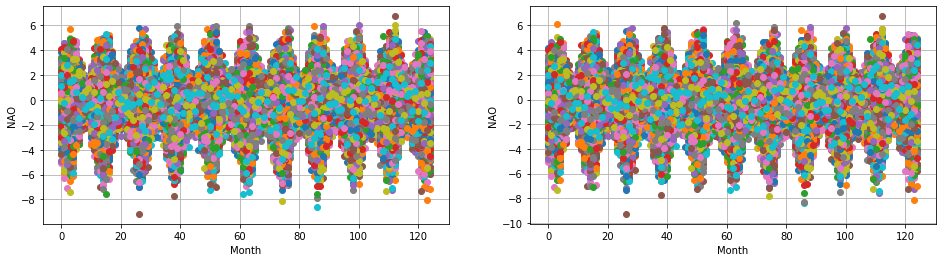

In [7]:
NAO_anom = ds_NAO['NAO'] - ds_NAO['NAO'].mean('start_year') # this is rough calculation (don't use this for final analysis)
# removing mean does not seem to make any difference. So let's stick with NAO, which we computed using sea-level pressure anomalies.

fig = plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(ds_NAO['NAO'].isel(start_year=year, r=r),'o')
        
plt.grid('on')
plt.ylabel('NAO')
plt.xlabel('Month')
        
        
plt.subplot(1,2,2)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_anom.isel(start_year=year, r=r),'o')
        
plt.grid('on')
plt.ylabel('NAO')
plt.xlabel('Month')

#### Seasonal dependence

At first, instead of looking at all members, we look at runs that have strong positive (or negative) NAO phase in the first DJF. We set cutoff for NAO+ indices to be greater than 2. we then examine how the system evolves over time and how surface properties change. For this, we first compute seasonal-mean NAO indices and isolate members having NAO > 2. in first DJF.

It is interesting to see that, if we look at members that have strong NAO+ phase in the first DJF, they tend not to have verty strong NAO phase in other seasons.

In [8]:
NAO_season = ds_NAO['NAO'].copy()
tim = ds_NAO['time_val'].isel(start_year=0).drop('start_year')
NAO_season = NAO_season.assign_coords(time=tim)

NAO_season = NAO_season.isel(time=slice(1,len(NAO_season.time)-1)) # get rid of first Nov and last Mar for better seasonal avg

with ProgressBar():
    NAO_season = NAO_season.resample(time='QS-DEC').mean('time').compute()

Text(0.5, 0, 'Season from start')

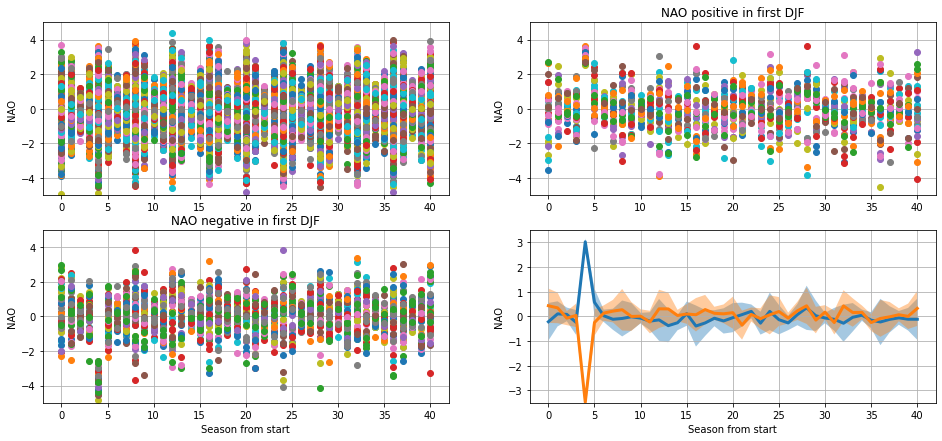

In [9]:
NAO_cut = 2.5
tim_ind = 4

fig = plt.figure(figsize=[16,7])


plt.subplot(2,2,2)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r).where(NAO_season.isel(start_year=year, r=r,time=tim_ind) >= NAO_cut), 'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.ylabel('NAO')
plt.title('NAO positive in first DJF')

plt.subplot(2,2,3)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r).where(NAO_season.isel(start_year=year, r=r,time=tim_ind) <= -NAO_cut),'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.xlabel('Season from start')
plt.ylabel('NAO')
plt.title('NAO negative in first DJF')

tmp = NAO_season.isel(time=0)

plt.subplot(2,2,1)
for year in range(0,len(ds_NAO['start_year'])):
    
    for r in range(0,10):
        
        plt.plot(NAO_season.isel(start_year=year, r=r),'o')
        
plt.grid('on')
plt.ylim([-5, 5])
plt.ylabel('NAO')

tmp1 = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut).mean(['start_year','r'])
tmp1_std = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut).std(['start_year','r'])
tmp2 = NAO_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut).mean(['start_year','r'])
tmp2_std = NAO_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut).std(['start_year','r'])

plt.subplot(2,2,4)
plt.plot(tmp1, lw=3)
plt.fill_between(range(0,41), tmp1 - 0.5*tmp1_std, tmp1 + 0.5*tmp1_std, alpha=0.4)
plt.plot(tmp2, lw=3)
plt.fill_between(range(0,41), tmp2 - 0.5*tmp2_std, tmp2 + 0.5*tmp2_std, alpha=0.4)
plt.grid('on')
plt.ylim([-3.5, 3.5])
plt.ylabel('NAO')
plt.xlabel('Season from start')

In [10]:
# check .where is performing as expected

tmp = NAO_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut)

# start_year = 43, 50 have NAO > 2.5
print(tmp.isel(time=0,r=1))

# NAO values are retained for all seasons for the aove start years
print(tmp.isel(r=1,start_year=43))

<xarray.DataArray 'NAO' (start_year: 57)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -0.58687797,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  2.64711829,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
        0.79226262,         nan])
Coordinates:
    time        object 1960-12-01 00:00:00
  * start_year  (start_year) int64 1960 1961 1962 1963 ... 2013 2014 2015 20

In [11]:
count_NAOp = xr.where(NAO_season.isel(time=0) >= NAO_cut, 1, 0)
count_NAOn = xr.where(NAO_season.isel(time=0) <= -NAO_cut, 1, 0)

# count NAO extreme cases
print(count_NAOp.sum(), count_NAOn.sum())

<xarray.DataArray 'NAO' ()>
array(16)
Coordinates:
    time     object 1960-12-01 00:00:00 <xarray.DataArray 'NAO' ()>
array(30)
Coordinates:
    time     object 1960-12-01 00:00:00


#### Overturning Anomalies

We can follow the same for overturning and look at time series of overturning anomalies that had strong +ve/-ve NAO phases in the first DJF.

In [9]:
#psi_anom = ds.zomsfatl.mean(['x']).max(dim='depthw') - ds_drift.zomsfatl.mean(['x']).max(dim='depthw')

psi_max= ds_anom['psi_anom'].rename({'time_counter':'time'})
psi_max = psi_max.assign_coords(y=ds_anom.nav_lat.isel(x=0), time=tim)
psi_max = psi_max.sel(y=slice(20.,65.))
#psi_max = psi_max.sel(y= [30., 35., 40., 45., 50., 55., 60.], method="nearest")
#psi_max = psi_max.isel(time=slice(1,len(psi_max['time'])-1))
#psi_season = psi_max.resample(time='QS-DEC').mean('time').persist()
#psi_month = psi_month.sel(y= [30.,  50.], method="nearest")

In [10]:
with Profiler() as prof, ResourceProfiler() as rprof, CacheProfiler() as cprof:
    %time psi_max = psi_max.compute()

CPU times: user 1min 22s, sys: 8min 7s, total: 9min 29s
Wall time: 9min 15s


In [11]:
visualize([prof, rprof, cprof], filename='profile_20_65.html')

Column(id='1240', ...)

In [12]:
%time psi_season = psi_max.isel(time=slice(1,len(psi_max['time'])-1)).resample(time='QS-DEC').mean('time').compute()

CPU times: user 157 ms, sys: 64.4 ms, total: 221 ms
Wall time: 218 ms


Text(0.5, 1.0, 'NAO negative DJF')

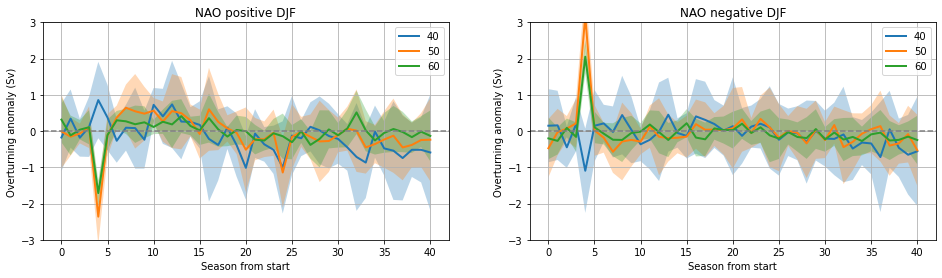

In [20]:
#tim_ind =4

import math

tmp1 = (psi_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut).mean(['start_year','r']))

tmp2 = (psi_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut).mean(['start_year','r']))

fig = plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
for y in range(2,len(tmp1.y), 2):
    tmp1_std = ((psi_season.sel(y= tmp1['y'].values[y], method="nearest"))
                .where(NAO_season.isel(time=tim_ind) >= NAO_cut).std(['start_year','r']))
    
    plt.plot(tmp1.isel(y=y), lw=2., label=math.floor(tmp1['y'].values[y]))
    plt.fill_between(range(0,41), (tmp1.isel(y=y) - 0.5*tmp1_std), (tmp1.isel(y=y) + 0.5*tmp1_std), alpha=0.3)

plt.axhline(y=0, color='grey', ls='--')
plt.legend()
plt.grid('on')
plt.ylim([-3.0, 3.0])
plt.ylabel('Overturning anomaly (Sv)')
plt.xlabel('Season from start')
plt.title('NAO positive DJF')

plt.subplot(1,2,2)
for y in range(2,len(tmp1.y), 2):
    tmp2_std = ((psi_season.sel(y= tmp1['y'].values[y], method="nearest"))
                .where(NAO_season.isel(time=tim_ind) <= -NAO_cut).std(['start_year','r']))
    
    plt.plot(tmp2.isel(y=y), lw=2., label=math.floor(tmp1['y'].values[y]))
    plt.fill_between(range(0,41), (tmp2.isel(y=y) - 0.5*tmp2_std), (tmp2.isel(y=y) + 0.5*tmp2_std), alpha=0.3)

plt.axhline(y=0, color='grey', ls='--')
plt.legend()
plt.grid('on')
plt.ylim([-3.0, 3.0])
plt.ylabel('Overturning anomaly (Sv)')
plt.xlabel('Season from start')
plt.title('NAO negative DJF')

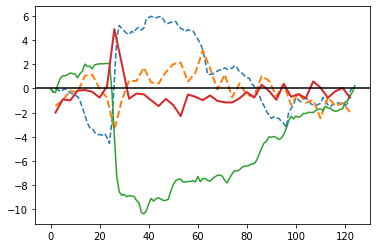

In [143]:
tmp1 = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind) >= NAO_cut).mean(['start_year','r'])
tmp2 = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind) <= -NAO_cut).mean(['start_year','r'])

tmp1_psi = (psi_season.where(NAO_season.isel(time=tim_ind) >= NAO_cut).mean(['start_year','r']))
tmp2_psi = (psi_season.where(NAO_season.isel(time=tim_ind) <= -NAO_cut).mean(['start_year','r']))

plt.plot(range(0,125), tmp1.cumsum('time').values - tmp1.values[0], ls='--')
plt.plot(range(2,123,3), 3*tmp1_psi.sel(y= 45., method="nearest"), lw=2, ls='--')
plt.plot(range(0,125), tmp2.cumsum('time').values - tmp2.values[0])
plt.plot(range(2,123,3), 3*tmp2_psi.sel(y= 45., method="nearest"), lw=2)
plt.axhline(y=0, color='k')

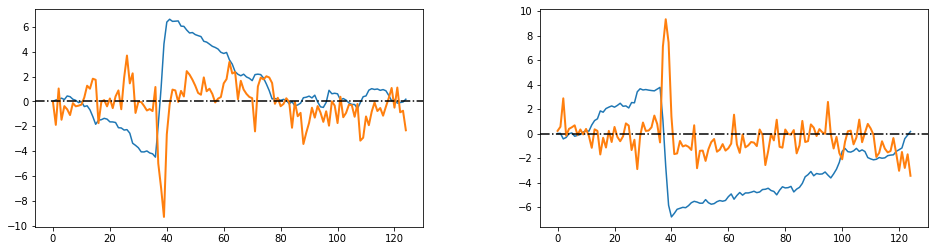

In [28]:
tmp1 = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind+8) >= NAO_cut).mean(['start_year','r'])
tmp2 = ds_NAO['NAO'].where(NAO_season.isel(time=tim_ind+8) <= -NAO_cut).mean(['start_year','r'])

tmp1_psi = (psi_max.where(NAO_season.isel(time=tim_ind+8) >= NAO_cut).mean(['start_year','r']))
tmp2_psi = (psi_max.where(NAO_season.isel(time=tim_ind+8) <= -NAO_cut).mean(['start_year','r']))

grid = plt.GridSpec(1, 2, wspace=0.3, hspace=1.2)
fig = plt.figure(figsize=[16,4]) 

ax = fig.add_subplot(grid[0, 0])
ax.plot(range(0,125), tmp1.cumsum('time').values - tmp1.values[0])
ax.plot(range(0,125), 3*tmp1_psi.sel(y= 50., method="nearest"), lw=2)
ax.axhline(y=0., ls='-.', color='k')

ax = fig.add_subplot(grid[0, 1])
ax.plot(range(0,125), tmp2.cumsum('time').values - tmp1.values[0])
ax.plot(range(0,125), 3*tmp2_psi.sel(y= 50., method="nearest"), lw=2)
ax.axhline(y=0., ls='-.', color='k')

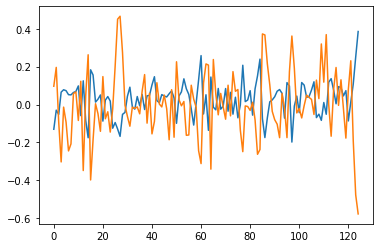

In [19]:
HT = ds_anom['hfbasin_atlantic'].mean('x')
HT = HT.assign_coords(y=ds.nav_lat.isel(x=0))

plt.plot(HT.sel(start_year=1967,r=0).sel(y=50., method="nearest"))

plt.plot(ds_NAO['NAO'].sel(start_year=1967,r=0)/10.)

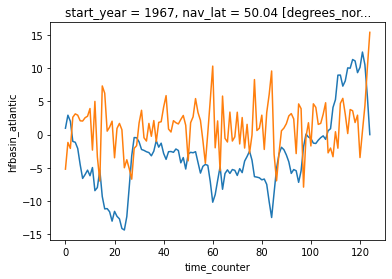

In [31]:
ds_NAO['NAO'].sel(start_year=1967,r=0).cumsum('time').plot()
(HT*40.).sel(start_year=1967,r=0).sel(y=50., method="nearest").plot()

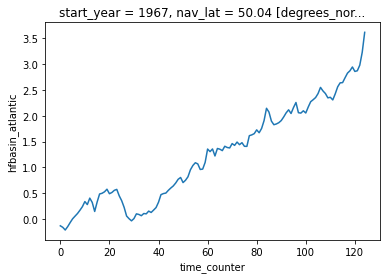

In [26]:
HT.sel(start_year=1967,r=0).sel(y=50., method="nearest").cumsum('time_counter').plot()

In [80]:
from __future__ import print_function
dsk = {'words': 'apple orange apple pear orange pear pear',
       'nwords': (len, (str.split, 'words')),
       ('val', 'orange'): 'orange',
       ('val', 'apple'): 'apple',
       ('val', 'pear'): 'pear',
       'count1': (str.count, 'words', ('val', 'orange')),
       'count2': (str.count, 'words', ('val', 'apple')),
       'count3': (str.count, 'words', ('val', 'pear')),
       'out1': (format_str, 'count1', ('val', 'orange'), 'nwords'),
       'out2': (format_str, 'count2', ('val', 'apple'), 'nwords'),
       'out3': (format_str, 'count3', ('val', 'pear'), 'nwords'),
       'print1': (print_and_return, 'out1'),
       'print2': (print_and_return, 'out2'),
       'print3': (print_and_return, 'out3')}

dask.visualize(dsk)

NameError: name 'format_str' is not defined